In [1]:
dataset <- "ARPAL"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Liguria"
match_dist <- 15000
new_dataset <- "LIG"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
Sys.setlocale("LC_ALL", "UTF-8")
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


[1] "C/UTF-8/C/C/C/C"

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = units::set_units(10, "km")) |>
    st_drop_geometry() |>
    filter(!state %in% c("Piemonte", "Emilia-Romagna", "Toscana"), network != "DPC")
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(3546L, 2163L))) # Removing SARZANA and Monte Settepani: bad data
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid)) |>
    compute()

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
# analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
# analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [6]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    tag_mergeable() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [7]:
path_from <- prepare_data_for_merge(conns$data)
saved_to <- merge_same_series(path_from, fs::path("db", "tmp"), new_dataset, tagged_analysis, metadata, data, 1, 2L * 365L, merging_datasets, desc(dataset), desc(sensor_last), desc(network))
merged_checkpoint(new_dataset, saved_to, metadata)


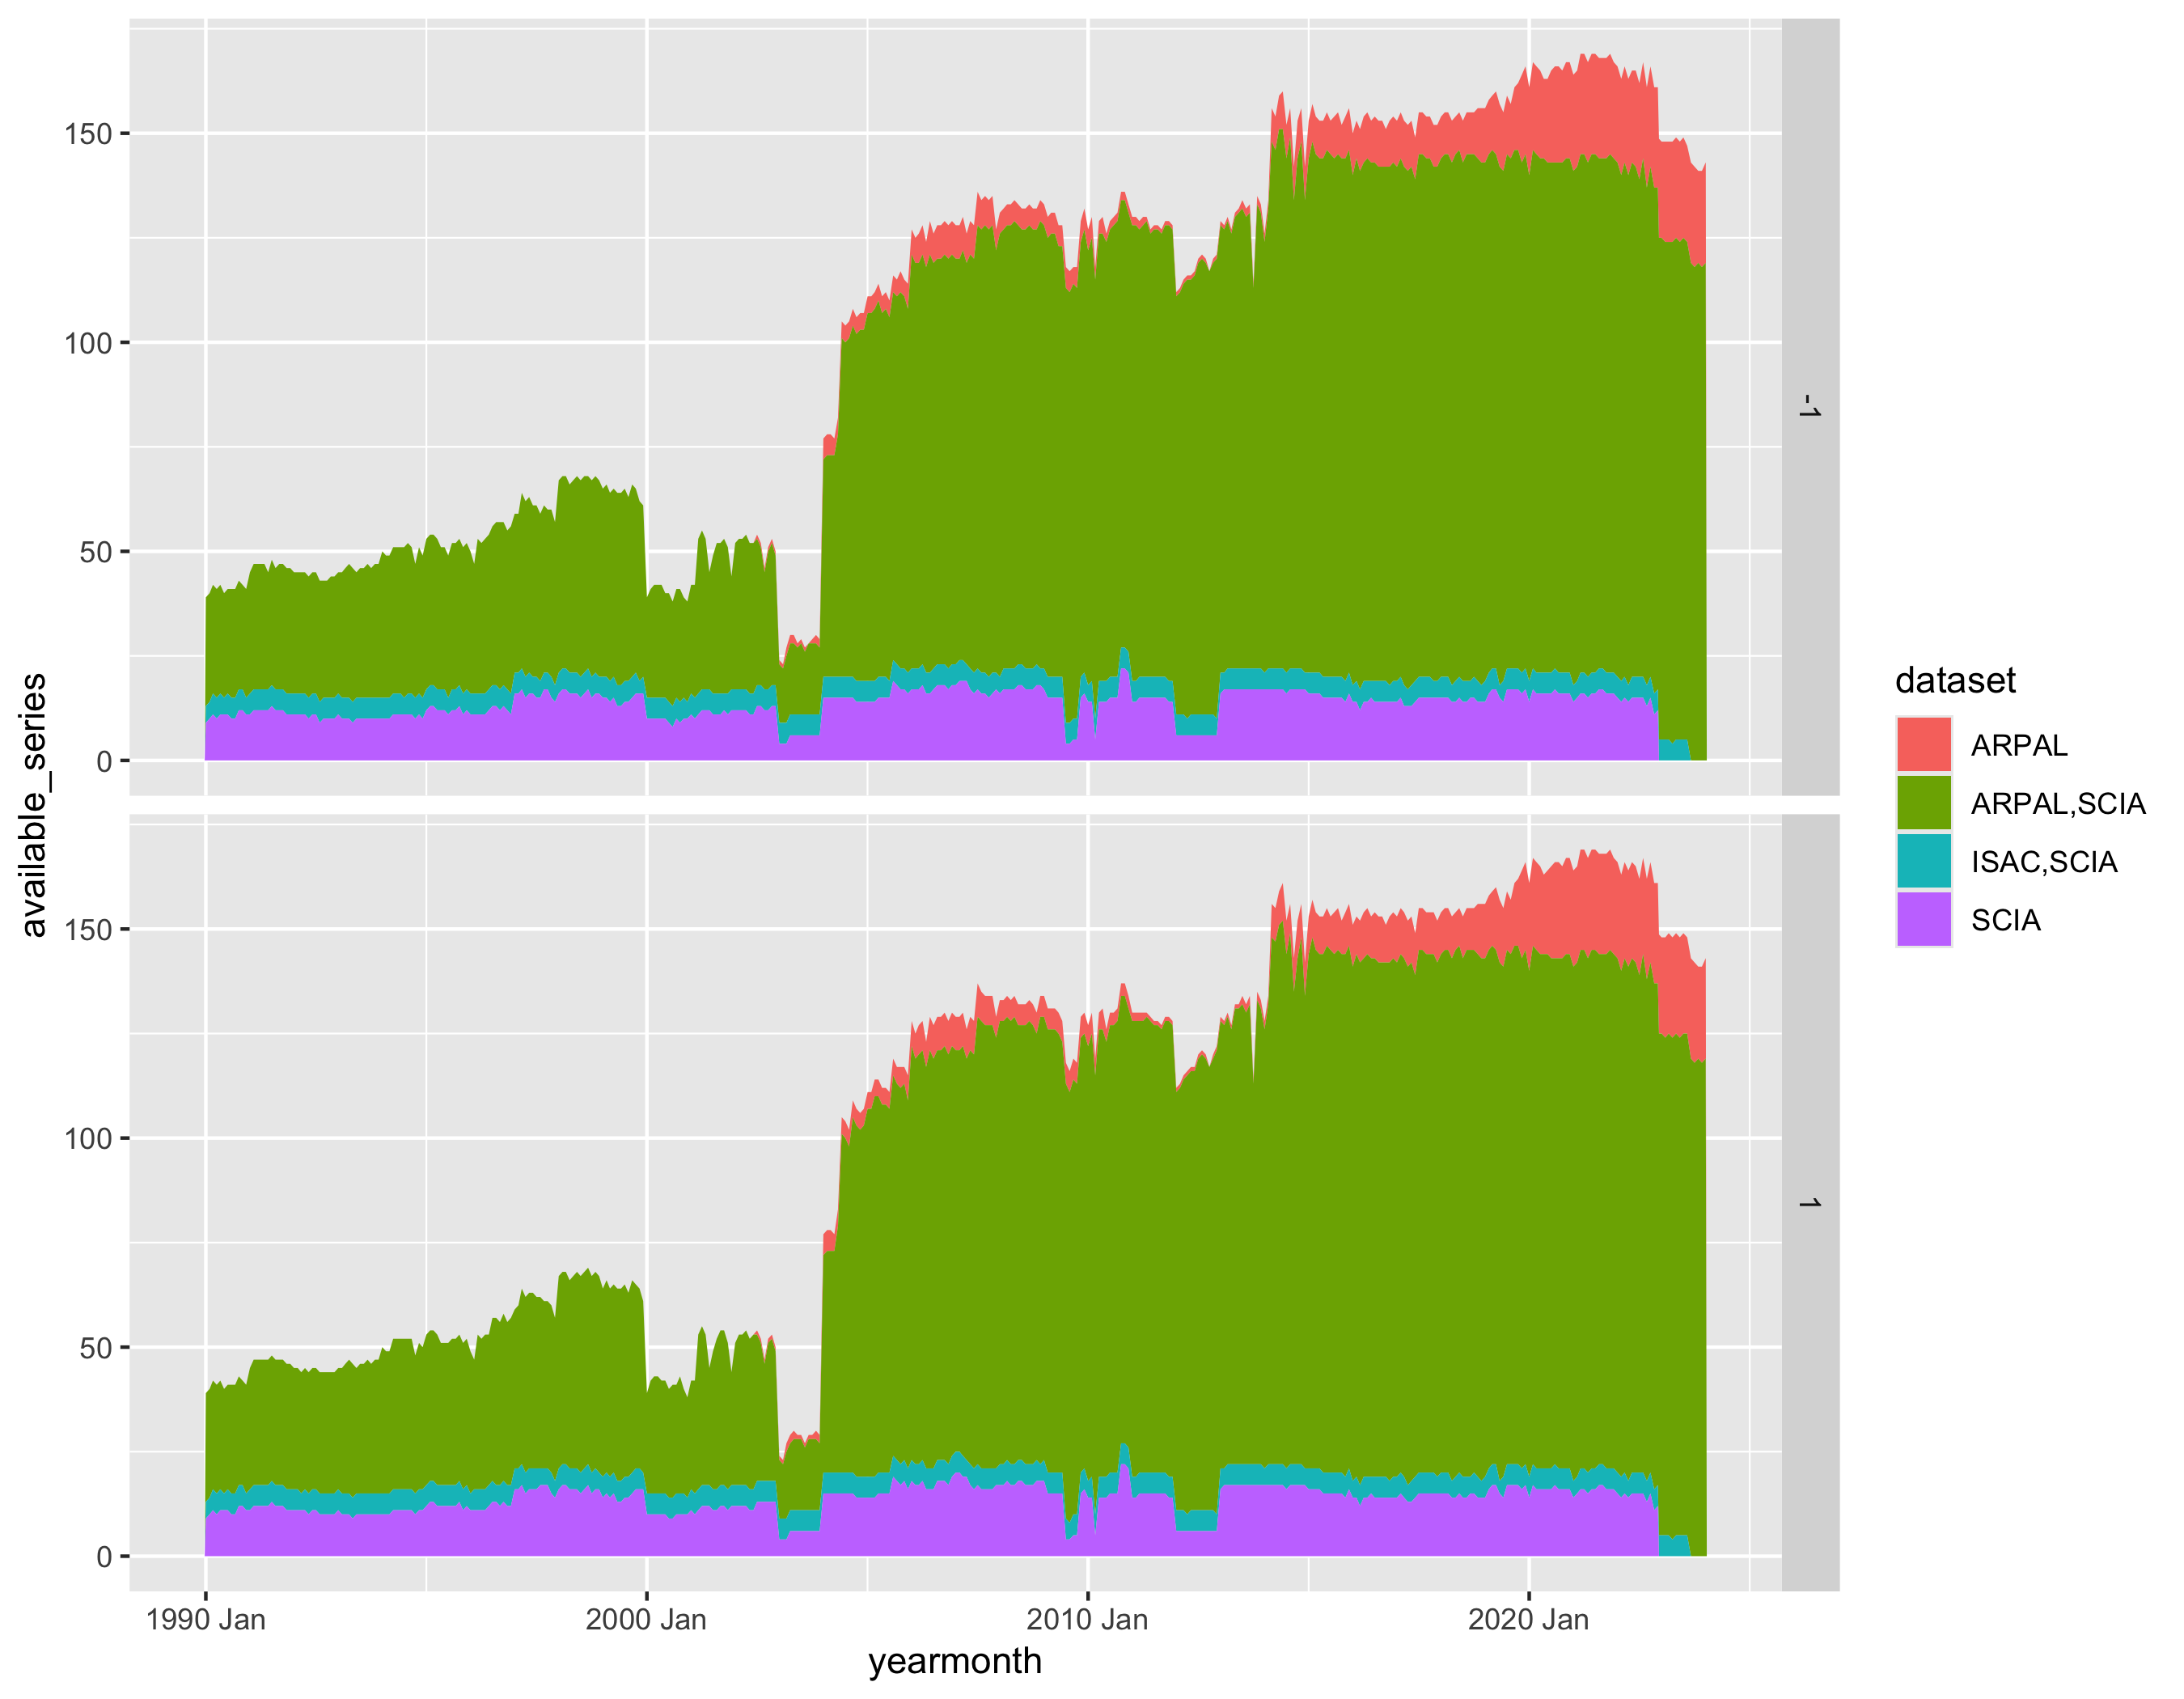

In [8]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = T)
pd$plot + facet_grid(variable ~ .)


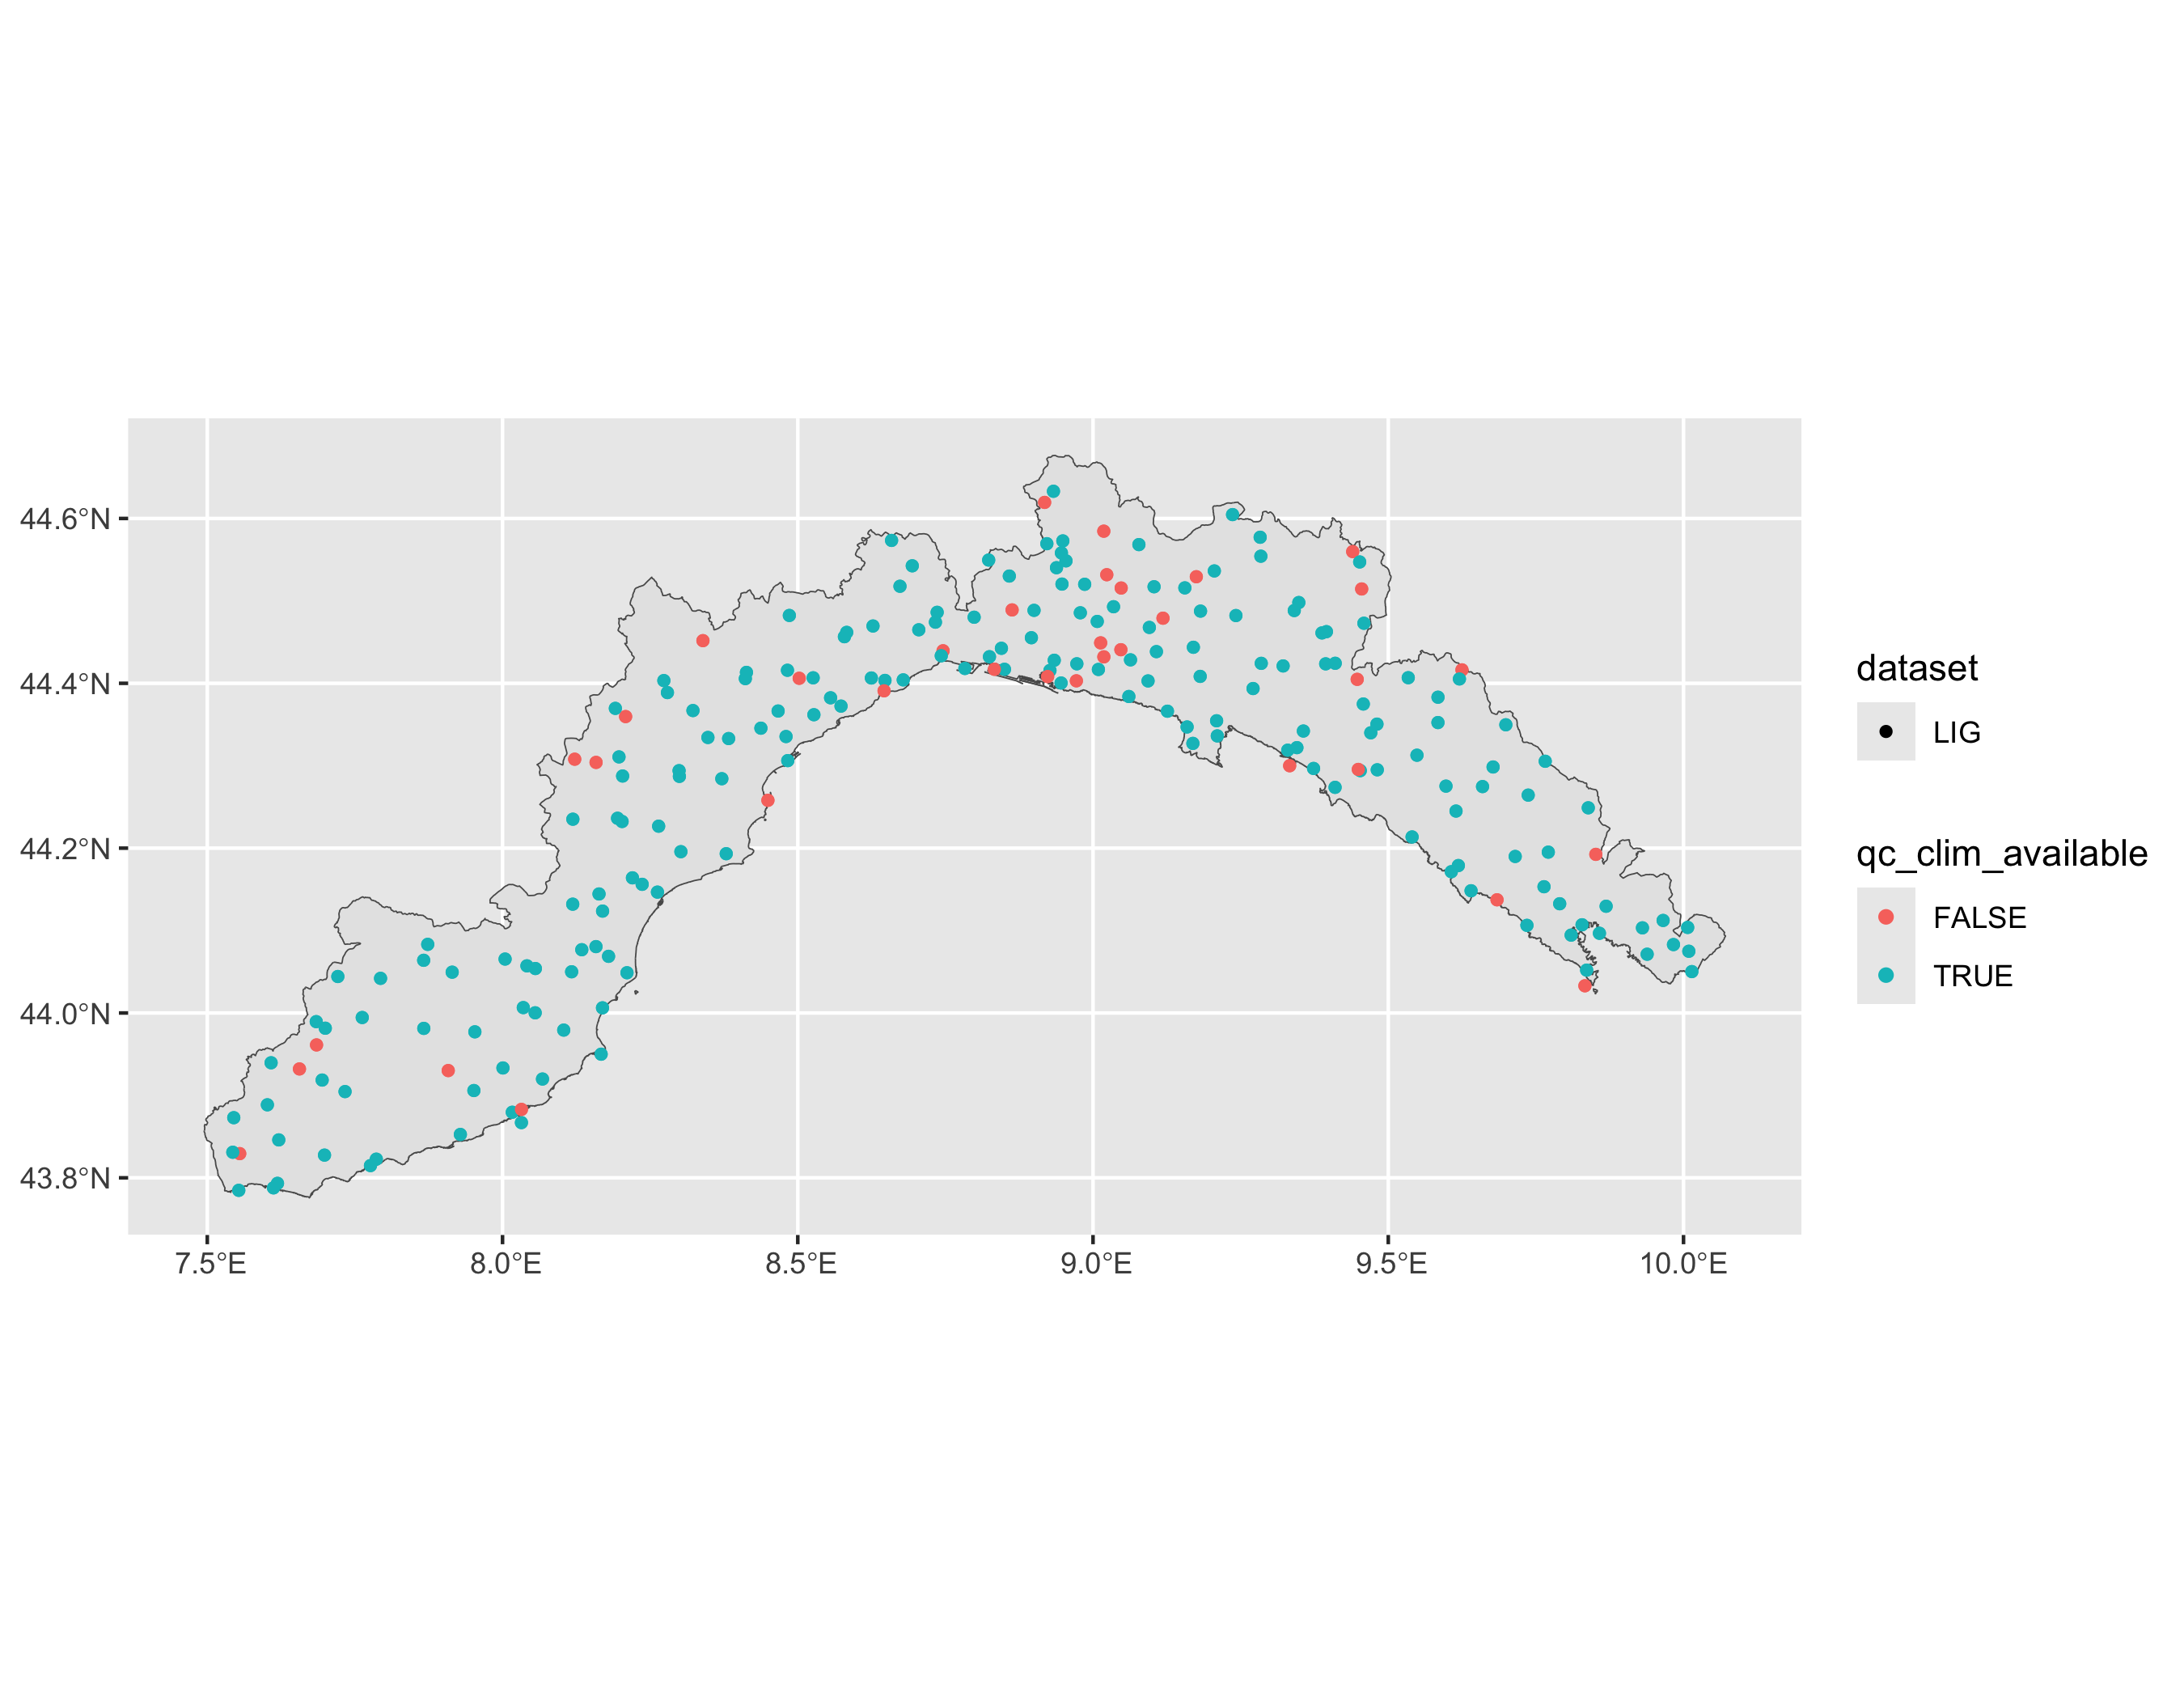

In [9]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot


In [10]:
merge_specs <- read_parquet(str_glue("db/extra/merge_specs/{new_dataset}.parquet")) |>
    mutate(km = k0 + 2 * k1 / pi)
merge_specs |>
    filter(abs(km) > 0.5) |>
    arrange(desc(abs(km))) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key")) |>
    relocate(km, name)


km,name,set,gkey,variable,metadata_rank,data_rank,skip_correction,dataset,sensor_key,force_merge,k0,k1,k2,k3,merged,offset
<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<lgl>,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>
-1.8252808,Loco Carchelli,LIG,75,-1,3,3,FALSE,SCIA,1997,FALSE,-1.2559138,-0.89435963,0.20221927,0.060643860,FALSE,0
-1.4300135,Loco Carchelli,LIG,75,1,3,3,FALSE,SCIA,1997,FALSE,-0.6112367,-1.28613151,0.22411819,-0.041346605,FALSE,0
1.2753141,Albenga,LIG,4,1,3,3,FALSE,SCIA,164,FALSE,1.8150949,-0.84788558,-0.10914938,-0.457901718,FALSE,0
-1.1844196,Albenga,LIG,4,-1,3,3,FALSE,SCIA,164,FALSE,-1.2807973,0.15138980,0.13881560,-0.663341393,FALSE,0
-0.9299700,STATALE,LIG,128,1,2,2,FALSE,ARPAL,166,FALSE,-0.7935044,-0.21435961,-0.05897784,0.161259812,TRUE,0
-0.7500000,AIROLE,LIG,1,-1,2,2,FALSE,ARPAL,1,FALSE,-0.7500000,0.00000000,0.00000000,0.000000000,TRUE,0
0.7488372,AIROLE,LIG,1,1,2,2,FALSE,ARPAL,1,FALSE,0.7488372,0.00000000,0.00000000,0.000000000,TRUE,0
-0.6729730,Airole,LIG,1,-1,4,4,FALSE,SCIA,155,FALSE,-0.6607466,-0.01920503,-0.09883079,0.001309348,TRUE,0
0.6725632,Airole,LIG,1,1,4,4,FALSE,SCIA,155,FALSE,0.6610783,0.01804045,0.09819239,-0.001290412,TRUE,0


In [21]:
merge_specs |>
    filter(gkey == 128L) |>
    select(dataset, sensor_key, variable, data_rank, metadata_rank, km, k0, k1) |>
    left_join(metadata |> select(dataset, sensor_key, name), by = c("dataset", "sensor_key"))


dataset,sensor_key,variable,data_rank,metadata_rank,km,k0,k1,name
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
ARPAL,165,-1,1,1,0.00000000,0.00000000,0.00000000,STATALE
ARPAL,166,-1,2,2,0.23517692,0.00102759,0.36780091,STATALE
SCIA,3881,-1,3,3,-0.03909158,-0.04651430,0.01165958,Statale
SCIA,3882,-1,4,4,0.16091552,0.01500259,0.22919949,Statale
ARPAL,165,1,1,1,0.00000000,0.00000000,0.00000000,STATALE
ARPAL,166,1,2,2,-0.92996998,-0.79350441,-0.21435961,STATALE
SCIA,3881,1,3,3,-0.03056132,-0.05962288,0.04564980,Statale
SCIA,3882,1,4,4,-0.64145587,-0.61171192,-0.04672168,Statale
